# Probros Docs

In [1]:
import numpy as np
import probros as pr
np.random.seed(0)

## Meta PPL

We propose following syntax for writing general probabilistic programs.

(Let's see if we need to change this.)

At this point, a probabilistic program is a **single python function**.

```
probabilistic program ::=
    @pr.probabilistic_program
    def <name>(*arg):
        S

E ::=                               Expression
    c                                   constant
    x                                   variable

    [E_1, ..., E_n]                     array literal
    x[E_1, ..., E_n]                    array element

    uop E                               unary operation, uop in [not, -]
    E_1 op E_2                          binary operation, op in [+, -, *, /, **, <,  <=, >, >=, ==, !=, and, or]
    f(E_1, ..., E_n)                    function call, f in ??

    sample(E, d(E_1, ..., E_n))         sample expression
    observe(E_1, E_2, d(E_1, ..., E_n)) observe expression
    observe(E_1, E_2)                   boolean observe expression
    factor(E)                           factor expression

/*
    or less restrictive
    sample(E_1, E_2)                    sample expression
    observe(E_1, E_2, E_3)              observe expression
*/

L ::=                               Assignment Target
    x                                   variable
    x[E_1, ..., E_n]                    indexed assignment

S ::=                               Statement
    L = E                               assignment
    x = Vector(n, ?t, ?E)               vector constructor with size n and optional type and fill value
    x = Array(shape, ?t, ?E)            array constructor with shape n and optional type and fill value

    S1                                  sequence
    S2

    if E:                               if statement
        S1
    else:
        S2
    
    for i in range(m,n) :               for loop
        S

    while E:                            while loop
        S
```

The core probabilistic constructs are the following:

`sample(address: str, distribution: Distribution)`

`observe(value, address: str = None, distribution: Distribution = Dirac(True))`

`factor(logfactor, address: str = None)`

The `@pr.probabilistic_program` decorator, wraps a python function and traces all sample, observe, and factor statements during an execution.

### Why do we need addresses?

**Each execution of sample, observe, and factor statements should have an unique address!**

In [2]:
# Consider a program of a geometric distribution
@pr.probabilistic_program
def geometric(p: float):
    i = 0
    while True:
        b = pr.sample(f"b[{i}]", pr.Bernoulli(p))
        if b == 1:
            break
        i += 1
    return i

In [3]:
retval, logprob, trace = geometric(0.5)
retval, logprob, trace

(0,
 -0.6931471805599453,
 Trace(input=((0.5,), {}))
 0.: {'address': 'b[0]', 'kind': 'sample', 'value': 1, 'logprob': -0.6931471805599453, 'distribution': Bernoulli(p=0.5)}
 retval=0
 logprob: -0.6931471805599453)

In [4]:
trace.entries_by_address()

{'b[0]': {'address': 'b[0]',
  'kind': 'sample',
  'value': 1,
  'logprob': -0.6931471805599453,
  'distribution': Bernoulli(p=0.5)}}

Translation to Pyro would look like this, where **we need addresses**:
```
import pyro
import pyro.distributions as dist
def geometric(p: float):
    i = 0
    while True:
        b = pyro.sample(f"b[{i}]", dist.Bernoulli(p))
        if b == 1:
            break
        i += 1
    return i
```

The same program with simple "auto-generated" addresses is invalid:
```
def geometric(p: float):
    i = 0
    while True:
        b = pyro.sample("b", dist.Bernoulli(p))
        if b == 1:
            break
        i += 1
    return i
```
Pyro requires that you do not override values at addresses.

The same goes for Gen:

```
using Gen
function geometric(p: Float64):
    i = 0
    while true
        b = {"b"=>i} ~ bernoulli(p)
        if b == 1
            break
        end
        i += 1
    end
    return i
end
```

In order to not have to use f-strings, we can use `IndexedAddress("b",i)` instead, which can be translated to `f"b[{i}]` or `"b"=>i` depending on translation target.

Furthermore, the trace generated by `@pr.probabilistic_program` also uses the addresses.

Note that if you do not care about the translation to address-based PPLs and only care about the return values of a program, you may set addresses to `None` or a constant string.
However, this is not recommended.

### @pr.probabilistic_program

We can use the traces generated by running a function wrapped with `@pr.probabilistic_program` to make quick sanity checks.

It returns `retval, logprob, trace`: the return value, joint log probability, and trace (a list of dictionaries, one entry for each sample/observe/factor), respectively.

#### Example 1

In [5]:
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    for i in range(len(data)):
        pr.observe(data[i], f"flip_{i}", pr.Bernoulli(p))
    return p

data = np.array([0,0,1,1,1])

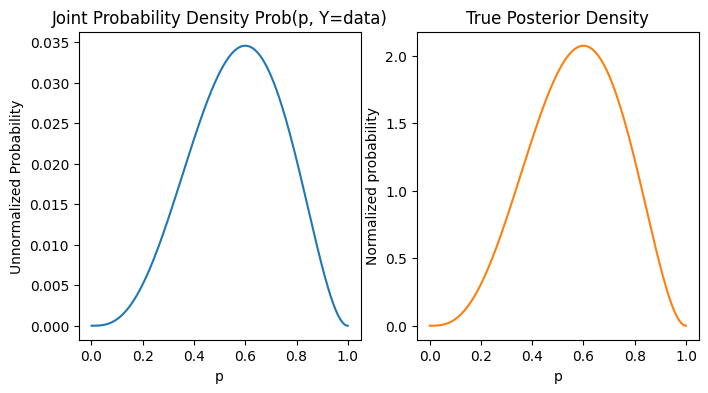

In [6]:
# We can make a few draws, and plot the result
import matplotlib.pyplot as plt
samples = [coin_flips(data)[:2] for _ in range(1000)]
samples = sorted(samples) # sort by p

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ps = np.array([s[0] for s in samples])
logprobs = np.array([s[1] for s in samples])
ax[0].plot(ps, np.exp(logprobs))
ax[0].set_xlabel("p")
ax[0].set_ylabel("Unnormalized Probability")
ax[0].set_title("Joint Probability Density Prob(p, Y=data)")
ax[1].plot(ps, np.exp(pr.Beta(np.sum(data)+1,np.sum(1-data)+1)._logprob(ps)), c="tab:orange")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Normalized probability")
ax[1].set_title("True Posterior Density")
plt.show()

In [7]:
pr.estimate_moments(10000, 2, coin_flips, data) # uses addresses
a, b = np.sum(data)+1, np.sum(1-data)+1
print("vs", a / (a+b), "and", a*b/((a+b)**2 * (a+b+1)))

100%|██████████| 10000/10000 [00:02<00:00, 4017.58it/s]

p:
  E[X] ≈ 0.5701097665357318
  E[(X - mu)^2] ≈ 0.030683259526015957
vs 0.5714285714285714 and 0.030612244897959183


#### Example 2

In [8]:
p = 0.7
X = np.array([geometric(p)[0] for _ in range(10_000)])
print(X.mean(), "vs", (1-p) / p)

0.4281 vs 0.42857142857142866


#### Example 3

In [9]:
@pr.probabilistic_program
def linear_regression(x, y):
    intercept = pr.sample("intercept", pr.Normal(0, 3))
    slope = pr.sample("slope", pr.Normal(0, 3))

    for i in range(len(x)):
        pr.observe(y[i], f"y_{i}", pr.Normal(slope * x[i] + intercept, 1.))

In [10]:
x = np.array([-1., -0.5, 0.0, 0.5, 1.0])
y = np.array([-3.2, -1.8, -0.5, -0.2, 1.5])

true_intercept_sigma_posterior = np.sqrt(1 / (1/3**2 + len(x)))
true_slope_sigma_posterior = np.sqrt(1 / (1/3**2 + x.dot(x)))

true_intercept_mean_posterior = (0/3**2 + sum(y)) * true_intercept_sigma_posterior**2
true_slope_mean_posterior = (0/3**2 + x.dot(y)) * true_slope_sigma_posterior**2


In [11]:
samples = [linear_regression(x,y) for _ in range(10_000)]
traces = [trace.entries_by_address() for retval, logprob, trace in samples]
lps = np.array([logprob for retval, logprob, trace in samples])
p = np.exp(lps)
p = p / p.sum()

slope = np.array([trace["slope"]["value"] for trace in traces])
intercept = np.array([trace["intercept"]["value"] for trace in traces])

p.dot(intercept), p.dot(slope)

(-0.812914496623212, 2.042525750642266)

In [12]:
pr.estimate_moments(10_000, 2, linear_regression, x, y)

100%|██████████| 10000/10000 [00:02<00:00, 3779.17it/s]

intercept:
  E[X] ≈ -0.8008501442677514
  E[(X - mu)^2] ≈ 0.18908281845025687
slope:
  E[X] ≈ 2.0238184210148535
  E[(X - mu)^2] ≈ 0.3850884147106431


In [13]:
true_intercept_mean_posterior, true_intercept_sigma_posterior ** 2

(-0.8217391304347826, 0.1956521739130435)

In [14]:
true_slope_mean_posterior, true_slope_sigma_posterior ** 2

(2.106382978723404, 0.38297872340425526)

### Boolean Observes

In discrete models it is often the case that you do want to observe that a predicate is true.

We can write this with `observe(predicate)`, which is equivalent to observing from a Dirac distribution `observe(predicate), None, Dirac(True))`.

#### Example

In [15]:
@pr.probabilistic_program
def Burglary():
    earthquake = pr.sample("earthquake", pr.Bernoulli(0.0001))
    burglary = pr.sample("burglary", pr.Bernoulli(0.001))
    alarm = earthquake or burglary
    if earthquake:
        phoneWorking = pr.sample("phoneWorking", pr.Bernoulli(0.7))
    else:
        phoneWorking = pr.sample("phoneWorking", pr.Bernoulli(0.99))
    if alarm:
        if earthquake:
            maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.8))
        else:
            maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.6))
    else:
        maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.2))

    called = maryWakes and phoneWorking
    pr.observe(called) # == observe(called, None, Dirac(True))

    return burglary

Observing a Dirac distribution easily leads to traces with probability 0.

In [16]:
Burglary()[-1]

Trace(input=((), {}))
0.: {'address': 'earthquake', 'kind': 'sample', 'value': 0, 'logprob': -0.00010000500033335834, 'distribution': Bernoulli(p=0.0001)}
1.: {'address': 'burglary', 'kind': 'sample', 'value': 0, 'logprob': -0.0010005003335835335, 'distribution': Bernoulli(p=0.001)}
2.: {'address': 'phoneWorking', 'kind': 'sample', 'value': 1, 'logprob': -0.01005033585350145, 'distribution': Bernoulli(p=0.99)}
3.: {'address': 'maryWakes', 'kind': 'sample', 'value': 1, 'logprob': -1.6094379124341003, 'distribution': Bernoulli(p=0.2)}
4.: {'address': 'observe_4', 'kind': 'observe', 'value': 1, 'logprob': 0.0, 'distribution': Dirac(value=True)}
retval=0
logprob: -1.6205887536215187

## Distributions

The distributions backend provides classes that wraps `scipy.stats` functions into following class structure:

```
class Distribution:
    def sample(self, size=None):
        raise NotImplementedError
    
    def _logprob(self, value):
        raise NotImplementedError
```

These classes are generated automatically with `scipy_distributions_gen.py.`

Currently, we have following distributions:
- Beta
- Cauchy
- Exponential
- Gamma
- HalfCauchy
- HalfNormal
- InverseGamma
- Normal
- StudentT
- Uniform
- Bernoulli
- Binomial
- DiscreteUniform
- Geometric
- HyperGeometric
- Poisson
- Dirichlet
- MultivariateNormal

More can be easily added.

Dirac is a custom distribution.

### Vectorization

In [17]:
# With the `size` argument we can generate multiple samples at once.
d = pr.Normal(0.,1.)
d.sample(size=10)

array([-0.47287969,  0.46006871, -2.13665468, -0.69442032,  0.43982269,
        0.80403728,  0.69551301, -2.23771063, -0.19555175, -0.86151932])

In [18]:
x = d.sample(size=(2,2))
x

array([[ 0.06347031, -0.36607587],
       [ 0.13478719,  0.2589199 ]])

In [19]:
# d._logprob(x) scores them individiually
d._logprob(x)

array([[-0.92095277, -0.9859443 ],
       [-0.92802233, -0.95245829]])

In [20]:
# d.logprob(x) computes the sum
d.logprob(x), d._logprob(x).sum()

(-3.787377692576725, -3.787377692576725)

In [21]:
# This also works for multivariate distributions
d = pr.MultivariateNormal([0.,0.] ,1.) # two dimensional
d.sample()

array([1.41262862, 0.6336156 ])

In [22]:
d.sample(size=10).shape, d.sample(size=(3,4)).shape

((10, 2), (3, 4, 2))

In [23]:
x = d.sample(size=(3,4))
d._logprob(x).shape, d.logprob(x)

((3, 4), -34.82895430511474)

In [24]:
# you can also pass lists of values to `logprob`
x = [d.sample() for _ in range(10)]
d.logprob(x)

-24.665180607800288

In [25]:
# you can also pass multiple parameters to distributions
d = pr.Bernoulli([0.1,0.9])
d.sample()

array([0, 1])

In [26]:
d.sample(size=(4,2))

array([[0, 1],
       [0, 0],
       [0, 1],
       [0, 1]])

**However, implicit broadcasting and vectorization is not recommended for translation purposes!**

The `sample` statement of our PPL does not accept a `size` argument.

However, you could pass an implicitely vectorized distribution like `Bernoulli([0.1,0.9])`.

This kind of vectorization is not supported by all translation targets (e.g. Gen and Turing).

**The recommended approach is explicit for-loops!**

```
b = Vector(2)
for i in range(2):
    b[i] = pr.sample(IndexedAddress("b",i), pr.Bernoulli(p[i]))
```

A sophisticated translator may simplify above expression with implicit vectorization, if it is supported in the target language (e.g. Pyro).

If you still want to use vectorization, we recommend to make it explicit in the syntax with `pr.IID` and `pr.Broadcasted`.

In [27]:
d = pr.IID(pr.Bernoulli([0.9]), 2)
d.sample()

array([1, 1])

In [28]:
d = pr.Broadcasted(pr.Bernoulli([0.1,0.9]))
d.sample()

array([1, 0])

In [29]:
d = pr.IID(pr.MultivariateNormal([0., 0.], 1), 3)
d.sample().shape

(3, 2)

#### Example 1:

In [30]:
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    for i in range(len(data)):
        pr.observe(data[i], pr.Bernoulli(p),)
    return p
data = [0,0,1,1,1]
coin_flips(data)

(0.2295533022590479,
 -inf,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.2295533022590479, 'logprob': 0.0, 'distribution': Uniform(loc=0, scale=1)}
 1.: {'address': Bernoulli(p=0.2295533022590479), 'kind': 'observe', 'value': 0, 'logprob': -inf, 'distribution': Dirac(value=True)}
 2.: {'address': Bernoulli(p=0.2295533022590479), 'kind': 'observe', 'value': 0, 'logprob': -inf, 'distribution': Dirac(value=True)}
 3.: {'address': Bernoulli(p=0.2295533022590479), 'kind': 'observe', 'value': 1, 'logprob': 0.0, 'distribution': Dirac(value=True)}
 4.: {'address': Bernoulli(p=0.2295533022590479), 'kind': 'observe', 'value': 1, 'logprob': 0.0, 'distribution': Dirac(value=True)}
 5.: {'address': Bernoulli(p=0.2295533022590479), 'kind': 'observe', 'value': 1, 'logprob': 0.0, 'distribution': Dirac(value=True)}
 retval=0.2295533022590479
 logprob: -inf)

In [31]:
# same model but explicitly vectorised
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    pr.observe(data, "flip", pr.IID(pr.Bernoulli(p), len(data)))
    return p
coin_flips(data)

(0.05631704283464389,
 -8.746204264408954,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.05631704283464389, 'logprob': 0.0, 'distribution': Uniform(loc=0, scale=1)}
 1.: {'address': 'flip', 'kind': 'observe', 'value': [0, 0, 1, 1, 1], 'logprob': -8.746204264408954, 'distribution': IID(Bernoulli(p=0.05631704283464389), 5)}
 retval=0.05631704283464389
 logprob: -8.746204264408954)

In [32]:
# same model but implicitly vectorised
@pr.probabilistic_program
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    pr.observe(data, "flip", pr.Bernoulli(p))
    return p
coin_flips(data)

(0.6512474464444042,
 -3.3933820684870692,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.6512474464444042, 'logprob': 0.0, 'distribution': Uniform(loc=0, scale=1)}
 1.: {'address': 'flip', 'kind': 'observe', 'value': [0, 0, 1, 1, 1], 'logprob': -3.3933820684870692, 'distribution': Bernoulli(p=0.6512474464444042)}
 retval=0.6512474464444042
 logprob: -3.3933820684870692)

#### Example 2

In [33]:
@pr.probabilistic_program
def gmm(K, data):
    p = pr.sample("p", pr.Uniform(0.,1))
    mu = pr.Vector(K)
    for k in range(K):
        mu[k] = pr.sample(pr.IndexedAddress("mu",k), pr.Normal(0.,1.))
    
    z = pr.Vector(len(data))
    for i in range(len(data)):
        z[i] = pr.sample(pr.IndexedAddress("z",i), pr.Bernoulli(p))
        pr.observe(data[i], pr.IndexedAddress("y",i), pr.Normal(mu[z[i]],1.))

data = np.hstack((pr.Normal(-1,1).sample(2), pr.Normal(1,1).sample(3)))
gmm(2, data)

(None,
 -20.16741634091196,
 Trace(input=((2, array([-1.31842713,  0.96380373,  1.44642161, -0.38060677,  2.01540414])), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.6961760883087962, 'logprob': 0.0, 'distribution': Uniform(loc=0.0, scale=1.0)}
 1.: {'address': 'mu[0]', 'kind': 'sample', 'value': 1.3133432568709384, 'logprob': -1.7813737883888545, 'distribution': Normal(loc=0.0, scale=1.0)}
 2.: {'address': 'mu[1]', 'kind': 'sample', 'value': -1.094563399055875, 'logprob': -1.5179730504810478, 'distribution': Normal(loc=0.0, scale=1.0)}
 3.: {'address': 'z[0]', 'kind': 'sample', 'value': 1, 'logprob': -0.3621526502032599, 'distribution': Bernoulli(p=0.6961760883087962)}
 4.: {'address': 'y[0]', 'kind': 'observe', 'value': -1.3184271303562787, 'logprob': -0.9439960183005424, 'distribution': Normal(loc=-1.094563399055875, scale=1.0)}
 5.: {'address': 'z[1]', 'kind': 'sample', 'value': 1, 'logprob': -0.3621526502032599, 'distribution': Bernoulli(p=0.6961760883087962)}
 6.: {'ad

In [34]:
# same model but explicitly vectorised
@pr.probabilistic_program
def gmm(K, data):
    p = pr.sample("p", pr.Uniform(0.,1))
    mu = pr.sample("mu", pr.IID(pr.Normal(0.,1.), 2))
    z = pr.sample("z", pr.IID(pr.Bernoulli(p),len(data)))
    pr.observe(data, "y", pr.Broadcasted(pr.Normal(mu[z],1.)))

gmm(2, data)

(None,
 -20.421629646994393,
 Trace(input=((2, array([-1.31842713,  0.96380373,  1.44642161, -0.38060677,  2.01540414])), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.81797737389063, 'logprob': 0.0, 'distribution': Uniform(loc=0.0, scale=1.0)}
 1.: {'address': 'mu', 'kind': 'sample', 'value': array([-0.87746706,  1.8617082 ]), 'logprob': -3.9558299903014316, 'distribution': IID(Normal(loc=0.0, scale=1.0), 2)}
 2.: {'address': 'z', 'kind': 'sample', 'value': array([1, 0, 1, 1, 1]), 'logprob': -2.507306692519475, 'distribution': IID(Bernoulli(p=0.81797737389063), 5)}
 3.: {'address': 'y', 'kind': 'observe', 'value': array([-1.31842713,  0.96380373,  1.44642161, -0.38060677,  2.01540414]), 'logprob': -13.958492964173487, 'distribution': Broadcasted(Normal(loc=[ 1.8617082  -0.87746706  1.8617082   1.8617082   1.8617082 ], scale=1.0))}
 retval=None
 logprob: -20.421629646994393)

In [35]:
# same model but implicetly vectorised
@pr.probabilistic_program
def gmm(K, data):
    p = pr.sample("p", pr.Uniform(0.,1))
    mu = pr.sample("mu", pr.Normal(pr.Vector(K,fill=0.),1.))
    z = pr.sample("z", pr.Bernoulli(pr.Vector(len(data),fill=p)))
    pr.observe(data, "y", pr.Normal(mu[z],1.))

gmm(2, data)

(None,
 -14.06290900846937,
 Trace(input=((2, array([-1.31842713,  0.96380373,  1.44642161, -0.38060677,  2.01540414])), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.31592163316620225, 'logprob': 0.0, 'distribution': Uniform(loc=0.0, scale=1.0)}
 1.: {'address': 'mu', 'kind': 'sample', 'value': array([0.2614101 , 1.44527501]), 'logprob': -2.916454608521023, 'distribution': Normal(loc=Vector([0.0, 0.0]), scale=1.0)}
 2.: {'address': 'z', 'kind': 'sample', 'value': array([0, 1, 1, 0, 0]), 'logprob': -3.4435705745056024, 'distribution': Bernoulli(p=Vector([0.31592163316620225, 0.31592163316620225, 0.31592163316620225, 0.31592163316620225, 0.31592163316620225]))}
 3.: {'address': 'y', 'kind': 'observe', 'value': array([-1.31842713,  0.96380373,  1.44642161, -0.38060677,  2.01540414]), 'logprob': -7.702883825442745, 'distribution': Normal(loc=[0.2614101  1.44527501 1.44527501 0.2614101  0.2614101 ], scale=1.0)}
 retval=None
 logprob: -14.06290900846937)